# Convolutional Neural Networks: Using Keras functional and sequential API for GTRSB



## Table of Contents

- [1 - Packages](#1)
    - [1.1 - Load the Data and Split the Data into Train/Test Sets](#1-1)

- [2 - The Functional API](#4)    
    - [2.1 - Forward Propagation](#4-3)  
    - [2.2 - Train the Model](#4-4)
- [3 - History Object](#5)
- [4 - Bibliography](#6)

<a name='1'></a>
## 1 - Packages



In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

<a name='1-1'></a>
### 1.1 - Load the Data and Split the Data into Train/Test Sets



In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader


# Set up image transformations
img_64x64_size_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),
])

gtsrb_path = "/content"
train_percent = 0.8

# Download the training dataset
train_dataset = torchvision.datasets.GTSRB(root=gtsrb_path, split='train', transform=img_64x64_size_transform, download=True)

# Download the test dataset
test_dataset = torchvision.datasets.GTSRB(root=gtsrb_path, split='test', transform=img_64x64_size_transform, download=True)



In [3]:

# Print the size of the datasets
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")

# Print the shape of an example image and label
# Assuming that the first element in train_dataset is (image, label)
example_image, example_label = train_dataset[0]
print(f"Shape of example image: {example_image.shape}")  # Should be (3, 64, 64)
print(f"Shape of example label: {example_label}")  # Should be () for a single label



Number of training examples: 26640
Number of test examples: 12630
Shape of example image: torch.Size([3, 64, 64])
Shape of example label: 0


In [4]:

# Prepare the data
X_test = []
Y_test = []

for img, label in test_dataset:
    X_test.append(img.numpy())
    Y_test.append(label)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Print the shape of the whole test dataset
print(f"Shape of test dataset images: {X_test.shape}")  # Should be (num_samples, 3, 64, 64)
print(f"Shape of test dataset labels: {Y_test.shape}")  # Should be (num_samples,)

Shape of test dataset images: (12630, 3, 64, 64)
Shape of test dataset labels: (12630,)


In [5]:
# Prepare the data
X_train = []
Y_train = []

for img, label in train_dataset:
    X_train.append(img.numpy())
    Y_train.append(label)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Print the shape of the whole training dataset
print(f"Shape of training dataset images: {X_train.shape}")  # Should be (num_samples, 3, 64, 64)
print(f"Shape of training dataset labels: {Y_train.shape}")  # Should be (num_samples,)

Shape of training dataset images: (26640, 3, 64, 64)
Shape of training dataset labels: (26640,)


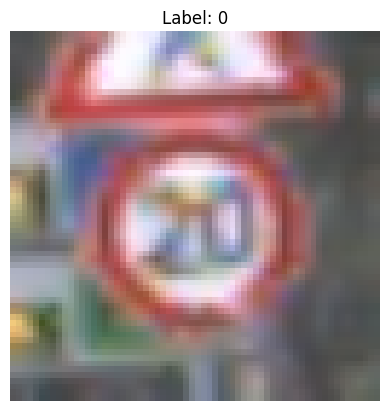

In [6]:
# Function to display an image
def imshow(image, label):
    # Convert the image from a tensor to a NumPy array
    image = image.permute(1, 2, 0).numpy()  # Change shape from (C, H, W) to (H, W, C)
    image = image * 255  # Scale pixel values back to [0, 255]
    image = image.astype('uint8')  # Convert to uint8 for display
    plt.imshow(image)
    plt.title(f'Label: {label}')  # Show the label in the title
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()  # Display the image

# Display the example image
imshow(example_image, example_label)

In [7]:

# Reshape X_train and X_test to (num_examples, 32, 32, 3)
X_train = X_train.transpose(0, 2, 3, 1)  # Change shape to (num_samples, 32, 32, 3)
X_test = X_test.transpose(0, 2, 3, 1)    # Change shape to (num_samples, 32, 32, 3)

# One-hot encode Y_train and Y_test
num_classes = 43  # Number of classes in GTSRB
Y_train = np.eye(num_classes)[Y_train]  # One-hot encode labels
Y_test = np.eye(num_classes)[Y_test]    # One-hot encode labels

# Print the new shapes
print(f"Shape of reshaped training dataset images: {X_train.shape}")  # Should be (num_samples, 32, 32, 3)
print(f"Shape of one-hot encoded training dataset labels: {Y_train.shape}")  # Should be (num_samples, num_classes)
print(f"Shape of reshaped test dataset images: {X_test.shape}")  # Should be (num_samples, 32, 32, 3)
print(f"Shape of one-hot encoded test dataset labels: {Y_test.shape}")  # Should be (num_samples, num_classes)

Shape of reshaped training dataset images: (26640, 64, 64, 3)
Shape of one-hot encoded training dataset labels: (26640, 43)
Shape of reshaped test dataset images: (12630, 64, 64, 3)
Shape of one-hot encoded test dataset labels: (12630, 43)


<a name='4'></a>
## 4 - The Functional API

We will use Keras' flexible [Functional API](https://www.tensorflow.org/guide/keras/functional) to build a ConvNet that can differentiate between 43 traffic signs



<img src="images/seq_vs_func.png" style="width:350px;height:200px;">

In [8]:
X_train = X_train/255.
X_test = X_test/255

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 26640
number of test examples = 12630
X_train shape: (26640, 64, 64, 3)
Y_train shape: (26640, 43)
X_test shape: (12630, 64, 64, 3)
Y_test shape: (12630, 43)


<a name='4-3'></a>
### 4.3 - Forward Propagation

In TensorFlow, there are built-in functions that implement the convolution.  TensorFlow builds computational graphs. In the [Functional API](https://www.tensorflow.org/guide/keras/functional), you create a graph of layers. This is what allows such great flexibility.


- **input_img = tf.keras.Input(shape=input_shape):**

Then, create a new node in the graph of layers by calling a layer on the `input_img` object:

- **tf.keras.layers.Conv2D(filters= ... , kernel_size= ... , padding='same')(input_img):**  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

- **tf.keras.layers.MaxPool2D(pool_size=(f, f), strides=(s, s), padding='same'):** `MaxPool2D()` downsamples your input using a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window.  For max pooling, you usually operate on a single example at a time and a single channel at a time.  [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

- **tf.keras.layers.ReLU():** computes the elementwise ReLU of Z (which can be any shape).  [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU).

- **tf.keras.layers.Flatten()**: given a tensor "P", this function takes each training (or test) example in the batch and flattens it into a 1D vector.  

    * If a tensor P has the shape (batch_size,h,w,c), it returns a flattened tensor with shape (batch_size, k), where $k=h \times w \times c$.  "k" equals the product of all the dimension sizes other than the first dimension.
    
    * For example, given a tensor with dimensions [100, 2, 3, 4], it flattens the tensor to be of shape [100, 24], where 24 = 2 * 3 * 4.  You can read the full documentation on [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten).

- **tf.keras.layers.Dense(units= ... , activation='softmax')(F):** given the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation on [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

In the last function above (`tf.keras.layers.Dense()`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize
weights when initializing the parameters.

Lastly,we define the output using the last of the function's compositions (in this example, a Dense layer):

- **outputs = tf.keras.layers.Dense(units=6, activation='softmax')(F)**



<a name='ex-2'></a>


 `convolutional_model` : `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE`.



 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Use 8 4 by 4 filters, stride 1, padding is "SAME"
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
 - **Conv2D**: Use 16 2 by 2 filters, stride 1, padding is "SAME"
 - **ReLU**
 - **MaxPool2D**: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the previous output.
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer: Apply a fully connected layer with 6 neurons and a softmax activation.

In [9]:

def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE

    Note that for simplicity, we hard-code some values
    such as the stride and kernel (filter) sizes.
    Normally, functions should take these values as function parameters.

    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process)
    """

    input_img = tf.keras.Input(shape=input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv2D(filters = 8, kernel_size=(4,4), strides = (1,1), padding='SAME')(input_img)
    ## RELU
    A1 = tfl.ReLU()(Z1)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1= tfl.MaxPool2D(  pool_size=(8, 8),    strides=8,    padding='same',)(A1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(filters = 16, kernel_size=(2,2), strides = (1,1), padding='SAME')(P1)
    ## RELU
    A2 = tfl.ReLU()(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2= tfl.MaxPool2D(  pool_size=(4, 4),    strides=4,    padding='same',)(A2)
    ## FLATTEN
    F = tfl.Flatten()(P2)
    ## Dense layer
    ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'"
    outputs = tfl.Dense(units=43, activation='softmax')(F)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [10]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

output = [['InputLayer', [(None, 64, 64, 3)], 0],
        ['Conv2D', (None, 64, 64, 8), 392, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 64, 64, 8), 0],
        ['MaxPooling2D', (None, 8, 8, 8), 0, (8, 8), (8, 8), 'same'],
        ['Conv2D', (None, 8, 8, 16), 528, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 8, 8, 16), 0],
        ['MaxPooling2D', (None, 2, 2, 16), 0, (4, 4), (4, 4), 'same'],
        ['Flatten', (None, 64), 0],
        ['Dense', (None, 43), 390, 'softmax']]


# output = [
#     ['InputLayer', [(None, 32, 32, 3)], 0],
#     ['Conv2D', (None, 32, 32, 8), 392, 'same', 'linear', 'GlorotUniform'],
#     ['ReLU', (None, 32, 32, 8), 0],
#     ['MaxPooling2D', (None, 4, 4, 8), 0, (8, 8), (8, 8), 'same'],
#     ['Conv2D', (None, 4, 4, 16), 528, 'same', 'linear', 'GlorotUniform'],
#     ['ReLU', (None, 4, 4, 16), 0],
#     ['MaxPooling2D', (None, 1, 1, 16), 0, (4, 4), (4, 4), 'same'],
#     ['Flatten', (None, 16), 0],
#     ['Dense', (None, 43), 741, 'softmax']
# ]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 8)           │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 16)            │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 43)                  │           2,795 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,715 (14.51 KB)

 Trainable params: 3,715 (14.51 KB)

 Non-trainable params: 0 (0.00 B)

Both the Sequential and Functional APIs return a TF Keras model object. The only difference is how inputs are handled inside the object model!

<a name='4-4'></a>
### 4.4 - Train the Model

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.1596 - loss: 3.7597 - val_accuracy: 0.0570 - val_loss: 3.7033
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1989 - loss: 3.6178 - val_accuracy: 0.0570 - val_loss: 3.6730
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1989 - loss: 3.5803 - val_accuracy: 0.0570 - val_loss: 3.6473
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1989 - loss: 3.5476 - val_accuracy: 0.0570 - val_loss: 3.6252
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1989 - loss: 3.5189 - val_accuracy: 0.0570 - val_loss: 3.6061
Epoch 6/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1989 - loss: 3.4934 - val_accuracy: 0.0570 - val_loss: 3.5895
Epoch 7/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1989 - loss: 3.4708 - val_accuracy: 0.0570 - val_loss: 3.5751
Epoch 8/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1989 - loss: 3.4508 - val_accuracy: 0

# Result:

We stagnate at accuracy: 0.1989 at epoch 5 after which the model's loss and accuracy curve keeps bouncing around. This is wehn we do not regularise the data.

When we regularise:


To do next:
- apply transfer learning
- not hardcode parameters and use trainable hyperparameters instead



<a name='5'></a>
## 5 - History Object

The history object is an output of the `.fit()` operation, and provides a record of all the loss and metric values in memory. It's stored as a dictionary that you can retrieve at `history.history`:

In [12]:
history.history

{'accuracy': [0.04718468338251114,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.05630630627274513,
  0.054729729890823364,
  0.05232732743024826,
  0.05232732743024826],
 'loss': [3.8082964420318604,
  3.7143871784210205,
  3.688267230987549,
  3.666177988052368,
  3.647212505340576,
  3.6308703422546387,
  3.616757869720459,
  3.6045517921447754,
  3.5939781665802,
  3.584810733795166,
  3.576849937438965,
  3.5699291229248047,
  3.56390643119812,
  3.5586557388305664,
  3.5540738105773926,
  3.5500681400299072,
  3.546563148498535,
  3.543491840362549,
  3.5407979488372803,
  3.5384302139282227],
 'val_accuracy': [0.05700712651014328,
  0.05700712651014328,
  0.05700712651014328,
  0.0

Now visualize the loss over time using `history.history`:

<ipython-input-13-957c1ea044b0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
<ipython-input-13-957c1ea044b0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

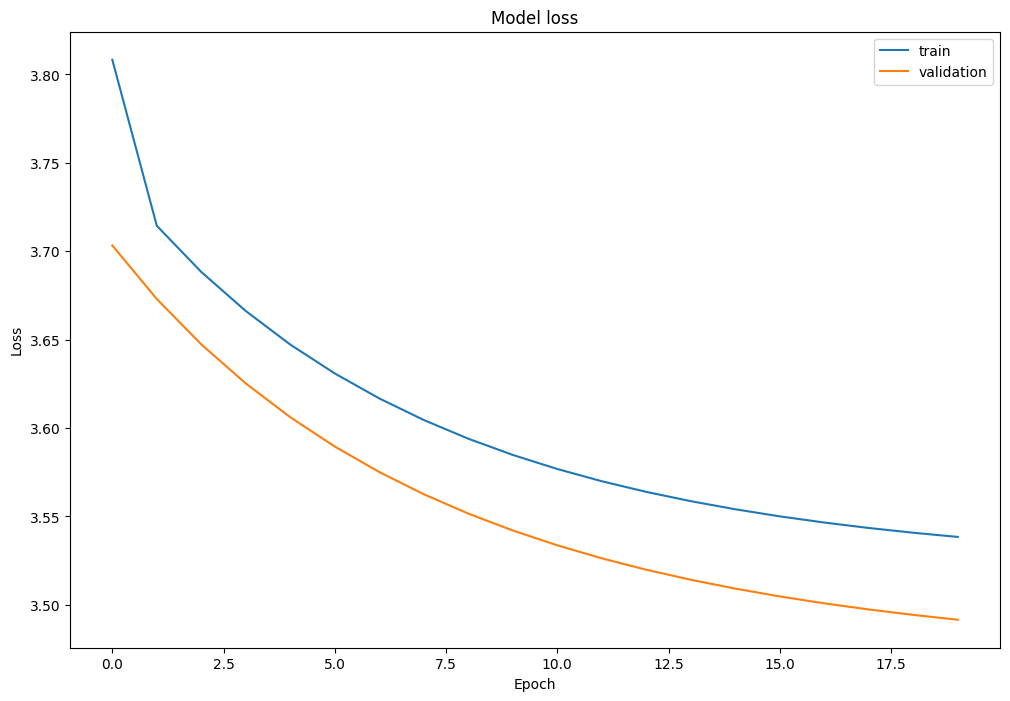

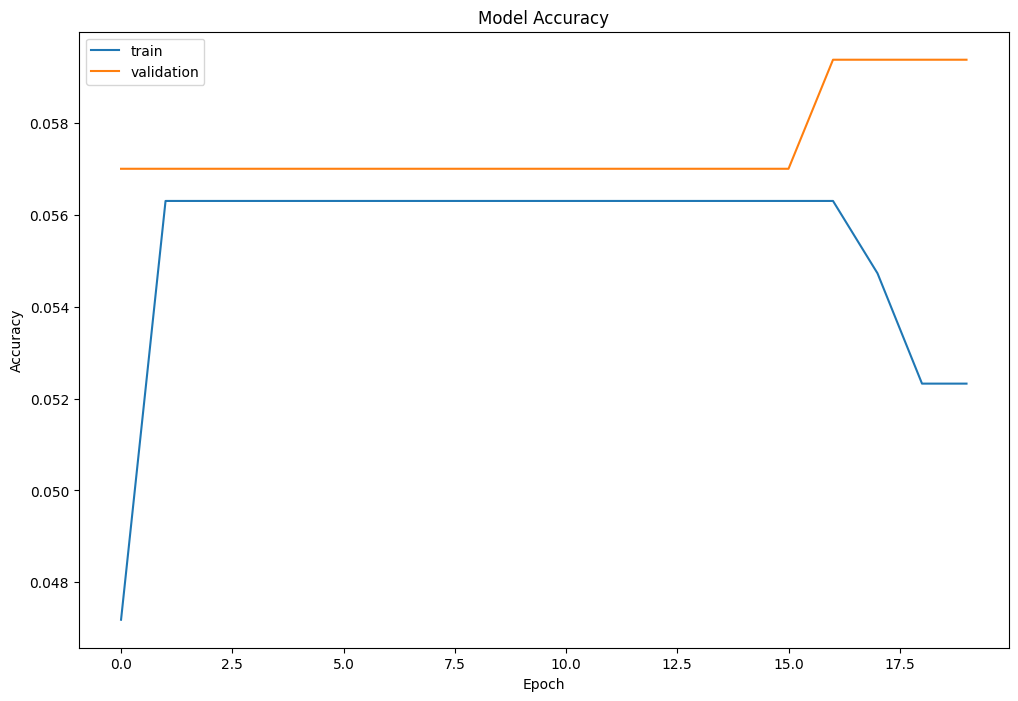

In [13]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on.
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [14]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(43, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#M odel display
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,319,659 (73.70 MB)

 Trainable params: 19,319,659 (73.70 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(128)
history2 = model.fit(train_dataset, epochs=32, validation_data=test_dataset)

Epoch 1/32
209/209 ━━━━━━━━━━━━━━━━━━━━ 48s 173ms/step - accuracy: 0.1945 - loss: 9.5677 - val_accuracy: 0.0594 - val_loss: 3.7279
Epoch 2/32
209/209 ━━━━━━━━━━━━━━━━━━━━ 52s 75ms/step - accuracy: 0.1460 - loss: 3.6875 - val_accuracy: 0.0594 - val_loss: 3.7037
Epoch 3/32
209/209 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.0236 - loss: 3.6486 - val_accuracy: 0.0594 - val_loss: 3.6739
Epoch 4/32
209/209 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.0261 - loss: 3.6072 - val_accuracy: 0.0570 - val_loss: 3.6394
Epoch 5/32
209/209 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.0198 - loss: 3.5628 - val_accuracy: 0.0570 - val_loss: 3.6050
Epoch 6/32
209/209 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.0125 - loss: 3.5193 - val_accuracy: 0.0570 - val_loss: 3.5745
Epoch 7/32
209/209 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.0095 - loss: 3.4802 - val_accuracy: 0.0570 - val_loss: 3.5499
Epoch 8/32
209/209 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.0105 - loss: 3.4485 -

<a name='6'></a>
## 6 - Bibliography

https://www.tensorflow.org/guide/keras/sequential_model

https://www.tensorflow.org/guide/keras/functional